## Data Preprocessing



**CLICKS DATASET FILE DESCRIPTION**

The file yoochoose-clicks.dat comprising the clicks of the users over the items.
Each record/line in the file has the following fields/format: Session ID, Timestamp, Item ID, Category

- Session ID – the id of the session. In one session there are one or many clicks. Could be represented as an integer number.
- Timestamp – the time when the click occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
- Item ID – the unique identifier of the item that has been clicked. Could be represented as an integer number.
- Category – the context of the click. The value "S" indicates a special offer, "0" indicates  a missing value, a number between 1 to 12 indicates a real category identifier,
 any other number indicates a brand. E.g. if an item has been clicked in the context of a promotion or special offer then the value will be "S", if the context was a brand i.e BOSCH,
 then the value will be an 8-10 digits number. If the item has been clicked under regular category, i.e. sport, then the value will be a number between 1 to 12. 
 
**BUYS DATSET FILE DESCRIPTION**

The file yoochoose-buys.dat comprising the buy events of the users over the items.
Each record/line in the file has the following fields: Session ID, Timestamp, Item ID, Price, Quantity

- Session ID - the id of the session. In one session there are one or many buying events. Could be represented as an integer number.
- Timestamp - the time when the buy occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
- Item ID – the unique identifier of item that has been bought. Could be represented as an integer number.
- Price – the price of the item. Could be represented as an integer number.

In [2]:
# Import necessary libraries
import pandas as pd

# CHANGE THIS TO THE DATA PATH ON YOUR COMPUTER
path = 'data/'

# Import click file
clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat')

# Import buy file
buys_df = pd.read_csv(path + 'yoochoose-buys.dat')

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_14268\3786542068.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat')


In [3]:
# Rename columns of the df
clicks_df.columns = ['session_id', 'timestamp', 'item_id', 'category']

# Convert timestamp to datetime
clicks_df['timestamp'] = pd.to_datetime(clicks_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

In [4]:
# Rename columns of the df
buys_df.columns = ['session_id', 'timestamp', 'item_id', 'price', 'quantity']

# Convert timestamp to datetime
buys_df['timestamp'] = pd.to_datetime(buys_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

In [6]:

# Analysing the shape of the clicks data
clicks_df.shape

(33003943, 4)

There are over 3Mi rows in the clicks dataset.

In [6]:
# Show summary data on the clicks dataset
clicks_df.describe(include='all').transpose()


C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_18588\2962751894.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  clicks_df.describe(include='all').transpose()


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
session_id,33003943.0,NaN,NaN,NaN,NaT,NaT,5620195.253239,3356589.837337,1.0,2691097.0,5516873.0,8527383.0,11562161.0
timestamp,33003943,32937844,2014-09-07 19:42:04.381000,4,2014-04-01 03:00:00.124,2014-09-30 02:59:59.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_id,33003943.0,NaN,NaN,NaN,NaT,NaT,216834479.888421,29819442.548417,214507224.0,214676070.0,214826810.0,214845422.0,1178837797.0
category,33003943.0,340.0,0.0,14548992.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we sould expect, no numeric fields, and therefore no summary statistics. Let's check for missing data:

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Check for missing values
missing_data = clicks_df.isnull().sum()
missing_percentage = missing_data/clicks_df.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualize missing data
sns.heatmap(clicks_df.isnull(), cmap='Reds', cbar=True, ax=axes[0])
axes[0].set_title('\nMissing Data Visualization', color='navy', size = 14)

# Visualize the percentage of missing data
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='royalblue', ax=axes[1])
axes[1].set_title('\nPercentage of Missing Data by Field', color='navy', size = 14)
axes[1].set_xlabel('Field')
axes[1].set_ylabel('Percentage Missing')

# Adjust layout
plt.tight_layout()
plt.show()

## Feature Engineering

We can basically split the problem into two. The first is a classical discrimation problem, where our goal is to predict a boolean label (buy or no buy) based on some input features X. The second part of the problem is to be treated as a recommendation problem. For simplicity, we will start with the discrimination problem as a guideline for our feature engineering efforts. Then, we apply what we have built to the recommendation problem in the next phase. The raitonale here is that these questions are ordered. That is, we first need to answer if the session is expected to result in a purchase. Only then we are interested in learning what the purchases are going to be

### Discrimination problem

Basically, our goal will be to predict buy and items based on a session. Therefore, our input data X is a dataset based on sessions, not clicks. Hence, the first thing we need to do is to construct this dataset. Then, the features that comprise X will be determined from what we take from the original datasets. We will start with a top-down approach, in which we start with a very simplistic model, and make incremental improvements towards our maximum performance. The first step is in training the dataset with a very naive approach: Number of clicks and buy probability. For that, we will use three ml models to benchmark:

 - Linear regression
 - Decision trees
 - Neural networks

In [ ]:
# Create unique sessions dataset
sessions = clicks_df.groupby('session_id').size().reset_index(name='count_of_clicks')

# Show the first few rows of the sessions dataset

sessions_merged = pd.merge(sessions, buys_df[['session_id','item_id']], on='session_id', how='left')

sessions_merged.head()

# Create y target variable
sessions_merged['purchase'] = sessions_merged['item_id'].notnull()

# Drop the item_id column
sessions_merged.drop('item_id', axis=1, inplace=True)

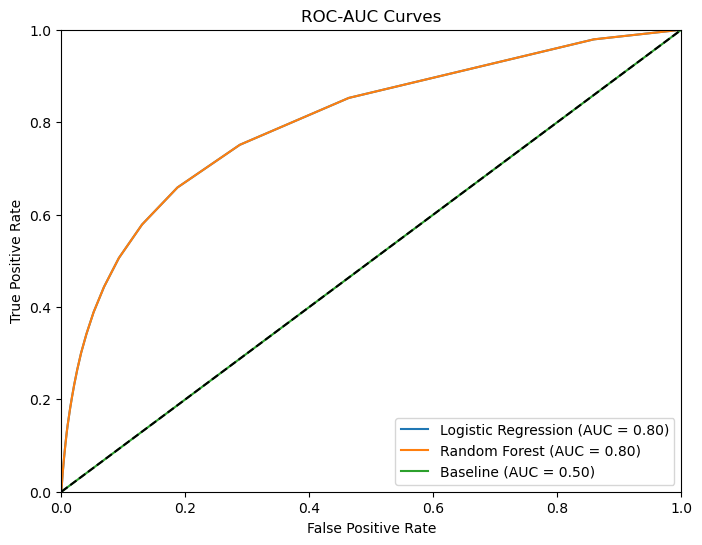

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Split the data into training and testing sets
X = sessions_merged[['count_of_clicks']]

y = sessions_merged['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a logistic regression model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train, y_train)


# Create a random forest model
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
log_reg_preds = log_reg.predict(X_test)
rf_preds = rf.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 scores
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
log_reg_precision = precision_score(y_test, log_reg_preds)
log_reg_recall = recall_score(y_test, log_reg_preds)
log_reg_f1 = f1_score(y_test, log_reg_preds)

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)

# Print the results
print('Logistic Regression Model')
print('Accuracy: {}'.format(log_reg_accuracy))
print('Precision: {}'.format(log_reg_precision))
print('Recall: {}'.format(log_reg_recall))
print('F1 Score: {}'.format(log_reg_f1))
print('\n')
print('Random Forest Model')
print('Accuracy: {}'.format(rf_accuracy))
print('Precision: {}'.format(rf_precision))
print('Recall: {}'.format(rf_recall))
print('F1 Score: {}'.format(rf_f1))


Logistic Regression Model
Accuracy: 0.8918026742732967
Precision: 0.640312084689061
Recall: 0.161743468937116
F1 Score: 0.2582521804424421


Random Forest Model
Accuracy: 0.8923213387812766
Precision: 0.6125478802970956
Recall: 0.2050205330192365
F1 Score: 0.3072156185900077


Plot ROC-AUC curve lift

In [ ]:
# Import the accuracy metric
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the logistic regression model
y_pred_log_reg = log_reg.predict_proba(X_test)[:, 1]

# Get the predicted probabilities for the random forest model
y_pred_rf = rf.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds for the logistic regression model
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_log_reg)

# Calculate the false positive rate, true positive rate, and thresholds for the random forest model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)

# Calculate the false positive rate, true positive rate, and thresholds for the baseline
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_test, [0] * len(y_test))

# Calculate the AUC for the logistic regression model
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Calculate the AUC for the random forest model
auc_rf = auc(fpr_rf, tpr_rf)

# Calculate the AUC for the baseline
auc_baseline = auc(fpr_baseline, tpr_baseline)

# Plot the ROC-AUC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label='Logistic Regression (AUC = {:.2f})'.format(auc_log_reg))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_baseline, tpr_baseline, label='Baseline (AUC = {:.2f})'.format(auc_baseline))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn import tree

# Get the first decision tree from the random forest model
decision_tree = rf.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(decision_tree, filled=True, feature_names=X.columns)
plt.show()


**Features to create and investigate**

1. Time since last click
2. Time of day
3. Clicks on category
4. Clicks on item
5. Item similarity?

Features of the buyers dataset:

1. Item price


Check item click occurance and buy occurence of items (to see if some bundling is necessary)